# Pretrain Policy with  `MPC dataset`

In [34]:
# %matplotlib
import numpy as np
import pickle
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from mujoco_parser import MuJoCoParserClass
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt
from util import r2quat

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from policy import GaussianPolicy
from pid import PID_ControllerClass
from motion_vae import MotionVariationalAutoEncoderClass

import mediapy as media

### Load  `MPC dataset`

In [35]:
# with open(file='../data/MPC_dataset_240324_bigggger_noise-2.pkl', mode='rb') as f:
#     dataset = pickle.load(f)
with open(file='../data/SMPL_MPC_dataset_240502.pkl', mode='rb') as f:
    dataset = pickle.load(f)

horizon = 200
action = torch.Tensor(dataset['action'].astype(np.float32))
root_pos = torch.Tensor(dataset['root_pos'])
root_rot = torch.Tensor(dataset['root_rot'])
root_vel = torch.Tensor(dataset['root_vel'])
root_ang_vel = torch.Tensor(dataset['root_ang_vel'])
dof_pos = torch.Tensor(dataset['dof_pos'])
dof_vel = torch.Tensor(dataset['dof_vel'])
local_key_pos = torch.Tensor(dataset['local_key_pos'])

del dataset

# qpos_batch = qpos_batch[:, :]
# qpos_batch = torch.cat((qpos_batch[:-2, :],qpos_batch[1:-1, :],qpos_batch[2:, :]),dim=1)
# qvel_batch = torch.cat((qvel_batch[:-2, :],qvel_batch[1:-1, :],qvel_batch[2:, :]),dim=1)

obs = torch.cat((root_pos[:,2:3], root_rot, root_vel, root_ang_vel, dof_pos, dof_vel, local_key_pos.reshape(-1, 12)), dim=1)
# obs = torch.cat((root_pos, root_rot, root_vel, root_ang_vel, dof_pos, dof_vel, local_key_pos.reshape(-1, 12)), dim=1)
# obs = torch.cat((root_pos, root_rot, root_vel, root_ang_vel, dof_pos, dof_vel), dim=1)

# action_batch = action_batch[2:]
obs_dim = obs.shape[1]
action_dim = action.shape[1]

print("obs : ", obs.shape)
print("action : ", action.shape)


obs :  torch.Size([39800, 97])
action :  torch.Size([39800, 37])


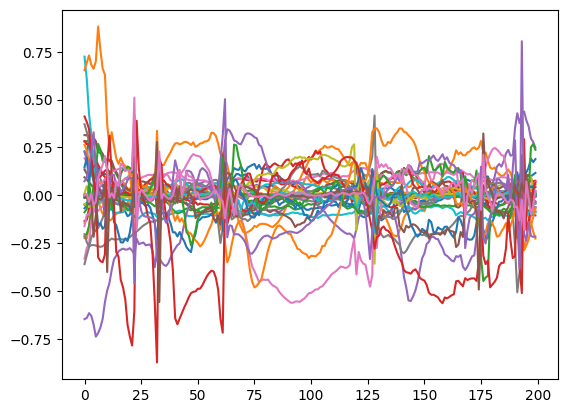

In [36]:
plt.plot(action[:200,:])

In [37]:
xml_path = '../asset/smpl_rig/scene_smpl_rig.xml'
env = MuJoCoParserClass(name='smplrig',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

dt:[0.0083] HZ:[120]
n_dof (=nv):[43]
n_geom:[67]
geom_names:['floor', 'base', 'base2lpelvis', 'base2rpelvis', 'base2spine1', 'spine2spine', 'spine2spine2', 'spine2spine3', 'spine2lcollar', 'spine2rcollar', 'neck2head', 'head', 'nose', 'lcollar2lshoulder', 'lshoulder2lelbow', 'lelbow2lwrist', 'lwrist2lindex1', 'lwrist2lmiddle1', 'lwrist2lpinky1', 'lwrist2lring1', 'lwrist2lthumb1', 'lindex1-lindex2', 'lindex2-lindex3', 'lindex3-lindextip', 'lmiddle1-lmiddle2', 'lmiddle2-lmiddle3', 'lmiddl3-lmiddletip', 'lring1-lring2', 'lring2-lring3', 'lring3-lringtip', 'lpinky1-lpinky2', 'lpinky2-lpinky3', 'lpinky3-lpinkytip', 'lthumb1-lthumb2', 'lthumb2-lthumb3', 'lthumb3-lthumbtip', 'rcollar2rshoulder', 'rshoulder2relbow', 'relbow2rwrist', 'rwrist2rindex1', 'rwrist2rmiddle1', 'rwrist2rpinky1', 'rwrist2rring1', 'rwrist2rthumb1', 'rindex1-rindex2', 'rindex2-rindex3', 'rindex3-rindextip', 'rmiddle1-rmiddle2', 'rmiddle2-rmiddle3', 'rmiddle3-rmiddletip', 'rring1-rring2', 'rring2-rring3', 'rring3-rringtip

### Load reference walking motion

In [38]:
motion_name = 'smplrig_walk_optimized_recon_local'
pkl_path = '../data/%s.pkl'%(motion_name)
with open(pkl_path, 'rb') as f:
    data_reference = pickle.load(f)
print ("[%s] loaded."%(pkl_path))

[../data/smplrig_walk_optimized_recon_local.pkl] loaded.


In [39]:
KEY_BODY_NAMES = ["right_ankle", "left_ankle", "right_wrist", "left_wrist"]
key_body_ids= np.array(env.get_idxs_body(KEY_BODY_NAMES))

In [40]:
GT_root_pos = torch.Tensor(data_reference['p_root'])
GT_root_rot = torch.Tensor(data_reference['R_root'])
GT_root_vel = torch.Tensor(data_reference['v_root'])
GT_root_ang_vel = torch.Tensor(data_reference['w_root'])
GT_dof_pos = torch.Tensor(data_reference['qpos'])
GT_dof_vel = torch.Tensor(data_reference['qvel'])
GT_local_key_pos = torch.Tensor((data_reference['xpos'][:,key_body_ids,:]-data_reference['xpos'][:,1,:].reshape(315,1,3)).reshape(315,12))

del data_reference


# qpos_batch = qpos_batch[:, :]
# qpos_batch = torch.cat((qpos_batch[:-2, :],qpos_batch[1:-1, :],qpos_batch[2:, :]),dim=1)
# qvel_batch = torch.cat((qvel_batch[:-2, :],qvel_batch[1:-1, :],qvel_batch[2:, :]),dim=1)

GT_obs = torch.cat((GT_root_pos[:,2].reshape(-1, 1), GT_root_rot, GT_root_vel, GT_root_ang_vel, GT_dof_pos, GT_dof_vel, GT_local_key_pos.reshape(-1, 12)), dim=1)


In [41]:
### PID
ctrl_ranges     = env.model.actuator_ctrlrange
n_ctrl          = env.model.nu
PID = PID_ControllerClass(
        name = 'PID',dim = n_ctrl,
        k_p = 1.0, k_i = 0.0, k_d = 0.004,
        out_min = ctrl_ranges[:,0],
        out_max = ctrl_ranges[:,1],
        dt = 0.00833,
        ANTIWU  = True)
PID.reset()

MotionVAEPolicy = MotionVariationalAutoEncoderClass(
    name     = 'VAE-MPC',
    x_dim    = obs_dim,
    y_dim    = action_dim,
    c_dim    = 1,
    z_dim    = 10,
    h_dims   = [256,256],
    pid      = PID,
    actv_enc = nn.ReLU(),
    actv_dec = nn.ReLU(),
    actv_out = None,
    # var_max  = 0.1,
    device   ='cpu',
    )

RunningMeanStd:  97


In [42]:
# class MPCDataset(Dataset):
#     def __init__(self, obs, act):
#         # self.obs = obs
#         # self.obs = (self.obs - self.obs.mean(dim=0)) / self.obs.std(dim=0)
#         self.act = act[:]# * env.model.actuator_gear[:, 0]
#         # self.act = (self.act - self.act.mean(dim=0)) / self.act.std(dim=0)
#         self.next_obs = obs[1:]
#         self.obs = obs[:-1]

#         assert self.obs.shape[0] == self.act.shape[0]

#     def __len__(self):
#         return self.obs.shape[0]

#     def __getitem__(self,idx):
#         return torch.cat((self.obs[idx], self.next_obs[idx])), self.act[idx]

In [43]:
class MPCDataset(Dataset):
    def __init__(self, obs, act, obs_ref, horizon=200):
        # self.obs = obs
        # self.obs = (self.obs - self.obs.mean(dim=0)) / self.obs.std(dim=0)
        self.act = act[:]# * env.model.actuator_gear[:, 0]
        # self.act_mean = self.act.mean(dim=0)
        # self.act_std = self.act.std(dim=0)
        # self.act = (self.act - self.act_mean) / self.act_std
        # self.next_obs = obs[1:]
        self.obs = obs[:]
        self.obs_scale = torch.max(self.obs,dim=0).values - torch.min(self.obs,dim=0).values
        self.act_scale = torch.max(self.act,dim=0).values - torch.min(self.act,dim=0).values
        self.noise_rate = 0.00
        self.obs_ref = obs_ref
        self.horizon = horizon

        assert self.obs.shape[0] == self.act.shape[0]

    def __len__(self):
        return self.obs.shape[0]

    def __getitem__(self,idx):
        first_frame = int(idx/self.horizon)
        t=min(first_frame+(idx%self.horizon),314)
        t=torch.tensor([t/314.])
        # return torch.cat((self.obs[idx], self.obs_ref[t])), self.act[idx]
        prev_idx = idx - 1
        obs_noise = torch.randn_like(self.obs[idx])*self.obs_scale*self.noise_rate
        act_noise = 0 # torch.randn_like(self.act[idx])*self.act_scale*self.noise_rate
        if idx % self.horizon == 0:
            prev_idx = idx
        return self.obs[idx]+obs_noise, t, self.act[idx]+act_noise, self.obs[prev_idx]

In [44]:
train_dataset = MPCDataset(obs, action, GT_obs, horizon)
train_dataloader = DataLoader(train_dataset, batch_size=4000, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [45]:
def linear_decay_lr(start_lr, end_lr, epoch, total_epochs):
    """
    선형적으로 감소하는 learning rate를 계산하는 함수
    
    :param start_lr: 시작 learning rate
    :param end_lr: 끝 learning rate
    :param epoch: 현재 에포크
    :param total_epochs: 총 에포크 수
    :return: 선형 감소된 learning rate
    """
    return end_lr + (start_lr - end_lr) * (1 - epoch / total_epochs)


In [13]:
num_epoch = 1000
optimizer = optim.Adam(MotionVAEPolicy.parameters(), lr=3e-4, eps=1e-8, betas=(0.9, 0.95))
loss = torch.nn.MSELoss()

# policy.action_mean_std.train()
for epoch in range(num_epoch):
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for x, t, y, prev_x in tepoch:
            
            tepoch.set_description(f"Epoch {epoch+1}")
            PID.reset()
            optimizer.zero_grad()
                
            # pred = MotionVAEPolicy.xc_to_y(x=x,c=None,dc=x[:,:int(x.shape[1]/2)]) # supervised
            # l = criterion(pred, y)
            beta = linear_decay_lr(0.001, 0.0001, epoch, num_epoch)
            loss,loss_info=MotionVAEPolicy.loss_total(x=x, c=t, prev_x=prev_x, y=y, beta=beta)
            loss.backward()
            optimizer.step()
            
            tepoch.set_postfix(recon_loss=float(loss_info['loss_recon_out']),kl_loss=float(loss_info['loss_kl_out']),total_loss=float(loss_info['loss_total_out']),beta=beta)

        # if epoch%2 == 0 and epoch > 0:
        #     fig, ax = plt.subplots()
        #     pred_ctrl = MotionVAEPolicy.xc_to_y(x[:1], c=None, STOCHASTICITY=False).detach().numpy()[0]
        #     ax.bar(np.arange(action_dim)-0.2, y[0], width = 0.35, align='edge', label='GT')
        #     ax.bar(np.arange(action_dim)+0.2, pred_ctrl, width = 0.35, align='edge', label='Predicted')
        #     ax.set_title("loss: {}".format(
        #         torch.mean(torch.abs(y[0]-pred_ctrl))
        #     ))
        #     ax.legend()
        #     ax.margins(0)
            # fig.canvas.draw()

            # image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            # image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))



Epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  5.58batch/s, beta=0.000101, kl_loss=5.39e-5, recon_loss=0.0124, total_loss=0.0124]


### Test pretrain model

In [13]:
PLOT = False
# policy.eval()
# MotionVAEPolicy.running_mean_std.eval()
# policy.is_deterministic = True

In [14]:
# Set which joints to control
ctrl_joint_names = env.ctrl_joint_names # <==
joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
n_ctrl_joint = len(ctrl_joint_names)

In [24]:
LOAD = True
file_path = "240502_walk_motionvae_PD_v2.pth"
if LOAD:
    MotionVAEPolicy.load_state_dict((torch.load(file_path)))

In [33]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='SMPL',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=False,FONTSCALE_VALUE=300)
env.update_viewer(azimuth=152,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.viewer_pause()
env.reset()
image_list = []
for t in np.arange(0,1):
    # assign the state in dataset (TODO : implement with `obs` variable)
    time_offset = 32
    rp = GT_root_pos[t+time_offset]
    rr = GT_root_rot[t+time_offset]
    rv = GT_root_vel[t+time_offset]
    rw = GT_root_ang_vel[t+time_offset]
    qpos = GT_dof_pos[t+time_offset]
    qvel = GT_dof_vel[t+time_offset]
    env.data.qvel = torch.cat((rv, rw, qvel))
    # env.data.qvel = np.zeros_like(env.data.qvel)
    env.forward(torch.cat((rp, rr, qpos)))
    env.data.qacc = np.zeros_like(env.data.qacc)


    PID.reset()
    prev_state = None
    for h in range(250-time_offset):
        # env.forward(torch.cat((rp[0:2],root_pos[t+h,2:3]+0.2, root_rot[t+h])),joint_idxs=np.arange(0,7))
        ctrl = action[t+h+time_offset]
        state = torch.from_numpy(np.concatenate((env.get_p_body('base')[2:3], r2quat(env.get_R_body('base')), env.get_qvel_joint('base')[0:3], env.get_qvel_joint('base')[3:6], env.data.qpos[env.rev_joint_idxs+6].copy(), env.data.qvel[env.rev_joint_idxs+5].copy(), (env.data.xpos[key_body_ids]-env.get_p_body('base')).reshape(12)), axis=-1)).type(torch.float32)
        phase = min(t+h+time_offset,314)
        phase = torch.tensor([phase/314.], dtype=torch.float32)
        # next_state = torch.from_numpy(np.concatenate((root_pos[next_idx,2:],root_rot[next_idx],root_vel[next_idx],root_ang_vel[next_idx],dof_pos[next_idx],dof_vel[next_idx],local_key_pos[next_idx]), axis=-1))
        # ext_state = torch.cat((state, next_state))
        if prev_state is None:
            prev_state = state
        # ext_state = MotionVAEPolicy.running_mean_std(ext_state)
        
        pred_ctrl = MotionVAEPolicy.xc_to_y(x=state,prev_x=prev_state,c=phase,STOCHASTICITY=False)
        pred_ctrl = pred_ctrl.detach().numpy()
        prev_state = state.clone()
        env.step(pred_ctrl)
        if env.loop_every(tick_every=1):
            env.plot_contact_info(h_arrow=0.3,rgba_arrow=[1,0,0,1],PRINT_CONTACT_BODY=False)

            # Plot world frame
            env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                    PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
            env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                    PLOT_AXIS=False,label="tick:[%d]"%(env.tick))

            # Plot contact information
            env.render()

            if PLOT:
                fig, ax = plt.subplots()
                ax.bar(np.arange(action_dim)-0.2, ctrl, width = 0.35, align='edge', label='GT')
                ax.bar(np.arange(action_dim)+0.2, pred_ctrl, width = 0.35, align='edge', label='Predicted')
                ax.set_title("loss: {}".format(
                    torch.mean(torch.abs(ctrl-pred_ctrl))
                ))
                ax.legend()
                ax.margins(0)
                fig.canvas.draw()

                image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
                image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

                image_list.append(image_from_plot)

env.close_viewer()

Pressed ESC
Quitting.


Exception: GLFW window does not exist but you tried to render.

In [ ]:
with media.VideoWriter(
    "behavior cloning eval.mp4", shape=(480, 640), fps=5) as w:
    for image in image_list:
        w.add_image(image)

```
v1 : 
v2 : 0.1 zero mean prior (cherry-pick = 76)
```

In [42]:
SAVE = True
file_path = "240502_walk_motionvae_PD_v2.pth"
if SAVE:
    torch.save(MotionVAEPolicy.state_dict(), file_path)

In [ ]:
policy.state_dict()